In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
# data form spark
df = pd.read_csv('data_week.csv', header=None, names=['ts', 'ts_week', 'number', 'pick_lat', 'pick_lng', 'drop_lat', 'drop_lng'])

In [59]:
df.shape

(8381183, 7)

In [60]:
df.dtypes

ts           object
ts_week      object
number        int64
pick_lat    float64
pick_lng    float64
drop_lat    float64
drop_lng    float64
dtype: object

In [62]:
df.drop(columns=['ts_week'])
df['ts'] = df['ts'].astype('datetime64[ns]')

In [63]:
df.head()

,ts,ts_week,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 01:37:17,2018-04-02T00:00:00.000+05:30,14626,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 02:02:27,2018-04-02T00:00:00.000+05:30,85490,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 02:06:44,2018-04-02T00:00:00.000+05:30,5408,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 02:08:00,2018-04-02T00:00:00.000+05:30,58940,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 02:09:29,2018-04-02T00:00:00.000+05:30,5408,12.899490,77.587270,12.934780,77.569950


In [64]:
df['ts_month'] = df['ts'].apply(lambda x: x.strftime('%Y-%B')) 

In [65]:
df.head()

,ts,ts_week,number,pick_lat,pick_lng,drop_lat,drop_lng,ts_month
0,2018-04-07 01:37:17,2018-04-02T00:00:00.000+05:30,14626,12.313621,76.658195,12.287301,76.602280,2018-April
1,2018-04-07 02:02:27,2018-04-02T00:00:00.000+05:30,85490,12.943947,77.560745,12.954014,77.543770,2018-April
2,2018-04-07 02:06:44,2018-04-02T00:00:00.000+05:30,5408,12.899603,77.587300,12.934780,77.569950,2018-April
3,2018-04-07 02:08:00,2018-04-02T00:00:00.000+05:30,58940,12.918229,77.607544,12.968971,77.636375,2018-April
4,2018-04-07 02:09:29,2018-04-02T00:00:00.000+05:30,5408,12.899490,77.587270,12.934780,77.569950,2018-April


In [66]:
df.set_index('number', inplace=True)
# create CohortGroup which picks up the rider's onboarding week
df['CohortGroup'] = df.groupby(level=0)['ts_month'].min()
df.reset_index(inplace=True)
df.head()

,number,ts,ts_week,pick_lat,pick_lng,drop_lat,drop_lng,ts_month,CohortGroup
0,14626,2018-04-07 01:37:17,2018-04-02T00:00:00.000+05:30,12.313621,76.658195,12.287301,76.602280,2018-April,2018-April
1,85490,2018-04-07 02:02:27,2018-04-02T00:00:00.000+05:30,12.943947,77.560745,12.954014,77.543770,2018-April,2018-April
2,5408,2018-04-07 02:06:44,2018-04-02T00:00:00.000+05:30,12.899603,77.587300,12.934780,77.569950,2018-April,2018-April
3,58940,2018-04-07 02:08:00,2018-04-02T00:00:00.000+05:30,12.918229,77.607544,12.968971,77.636375,2018-April,2018-April
4,5408,2018-04-07 02:09:29,2018-04-02T00:00:00.000+05:30,12.899490,77.587270,12.934780,77.569950,2018-April,2018-April


In [67]:
grouped = df.groupby(['CohortGroup', 'ts_month'])

# count the unique users per Group
cohorts = grouped.agg({'number': pd.Series.nunique})

cohorts.rename(columns={'number': 'total_rides'}, inplace=True)
cohorts.head(1000)

total_rides
CohortGroup   ts_month                  
2018-April    2018-April           22097
              2018-August          12100
              2018-December        14286
              2018-July            11438
              2018-June            11733
...                                  ...
2019-February 2019-January          1828
              2019-March            2932
2019-January  2019-January          1296
              2019-March             515
2019-March    2019-March            2205

[91 rows x 1 columns]

In [68]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the first ride.
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

# adding CohortPeriod per CohortGroup
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(1000)

total_rides  CohortPeriod
CohortGroup   ts_month                                
2018-April    2018-April           22097             1
              2018-August          12100             2
              2018-December        14286             3
              2018-July            11438             4
              2018-June            11733             5
...                                  ...           ...
2019-February 2019-January          1828             2
              2019-March            2932             3
2019-January  2019-January          1296             1
              2019-March             515             2
2019-March    2019-March            2205             1

[91 rows x 2 columns]

In [69]:
# reindexing the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['total_rides'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2018-April       22097
2018-August      20932
2018-December    21524
2018-July         3877
2018-June         2697
Name: total_rides, dtype: int64

In [70]:
user_retention=cohorts['total_rides'].unstack(0)
user_retention

CohortGroup,2018-April,2018-August,2018-December,2018-July,2018-June,2018-May,2018-November,2018-October,2018-September,2019-April,2019-February,2019-January,2019-March
CohortPeriod,,,,,,,,,,,,,
1,22097.0,20932.0,21524.0,3877.0,2697.0,2105.0,3162.0,2498.0,1855.0,5279.0,4746.0,1296.0,2205.0
2,12100.0,13004.0,3595.0,1057.0,648.0,323.0,1221.0,682.0,561.0,3417.0,1828.0,515.0,NaN
3,14286.0,9366.0,3414.0,668.0,442.0,412.0,788.0,815.0,917.0,2153.0,2932.0,NaN,NaN
4,11438.0,6774.0,3041.0,739.0,530.0,356.0,1163.0,1294.0,595.0,4437.0,NaN,NaN,NaN
5,11733.0,4734.0,11950.0,963.0,522.0,718.0,1858.0,954.0,1056.0,NaN,NaN,NaN,NaN
6,13076.0,11780.0,9423.0,946.0,874.0,1105.0,1534.0,1528.0,NaN,NaN,NaN,NaN,NaN
7,13003.0,12140.0,6628.0,1284.0,1404.0,730.0,2112.0,NaN,NaN,NaN,NaN,NaN,NaN
8,12968.0,12482.0,11181.0,2043.0,1001.0,1322.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12579.0,10660.0,16961.0,1583.0,1618.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
user_retention.T

CohortPeriod,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortGroup,,,,,,,,,,,,,
2018-April,22097.0,12100.0,14286.0,11438.0,11733.0,13076.0,13003.0,12968.0,12579.0,11919.0,17033.0,15820.0,17950.0
2018-August,20932.0,13004.0,9366.0,6774.0,4734.0,11780.0,12140.0,12482.0,10660.0,15685.0,14414.0,16583.0,NaN
2018-December,21524.0,3595.0,3414.0,3041.0,11950.0,9423.0,6628.0,11181.0,16961.0,16493.0,17668.0,NaN,NaN
2018-July,3877.0,1057.0,668.0,739.0,963.0,946.0,1284.0,2043.0,1583.0,2392.0,NaN,NaN,NaN
2018-June,2697.0,648.0,442.0,530.0,522.0,874.0,1404.0,1001.0,1618.0,NaN,NaN,NaN,NaN
2018-May,2105.0,323.0,412.0,356.0,718.0,1105.0,730.0,1322.0,NaN,NaN,NaN,NaN,NaN
2018-November,3162.0,1221.0,788.0,1163.0,1858.0,1534.0,2112.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-October,2498.0,682.0,815.0,1294.0,954.0,1528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-September,1855.0,561.0,917.0,595.0,1056.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


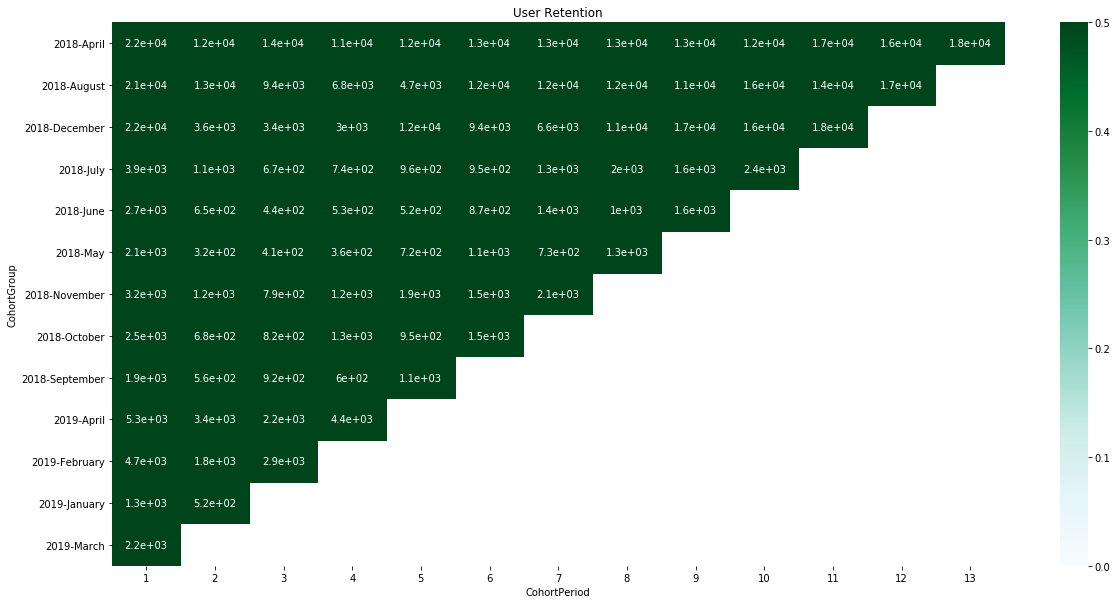

In [72]:
plt.figure(figsize=(20,10))
plt.title('User Retention')
sns.heatmap(data=user_retention.T, annot=True, vmin=0.0, vmax=0.5, cmap='BuGn')
plt.show()